# Background

The MBTA community law requires a by-right zone of 15 units per acre. There are [sources](https://mrsc.org/stay-informed/mrsc-insight/april-2017/visualizing-compatible-density) of images of different density levels online, but it's hard to understand in the abstract without a local example to refer to. This should answer the question 'what does this level of density look like in my community?'

In [18]:
# data i/o
from dvc.api import DVCFileSystem
from io import BytesIO
from zipfile import ZipFile
from dbfread import DBF

# plotting
import seaborn as sns

# processing
import geopandas as geo_pd
import pandas as pd
import numpy as np

# misc
import os
from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm.auto import tqdm

from math import pi, sqrt

%matplotlib inline

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

tqdm.pandas()

In [19]:
# neighboring cities are needed to get the true densities on the edges
cities = {
    "WALTHAM": {
      "id": "308",
      "FY": "23",
      "CY": "22"
    },
    "LEXINGTON" : {
        "id": "155",
        "FY": "22",
        "CY": "22"
    },
    "LINCOLN" : {
        "id": "157",
        "FY": "23",
        "CY": "22"
    },
    "WESTON" : {
        "id": "333",
        "FY": "22",
        "CY": "22"
    },
    "NEWTON" : {
        "id": "207",
        "FY": "23",
        "CY": "22" 
    },
    "WATERTOWN": {
        "id": "314",
        "FY": "23",
        "CY": "22"
    },
    "BELMONT" : {
        "id": "026",
        "FY": "23",
        "CY": "23"
    }
}

MBTA_density = 15

In [21]:
property_shapefiles_df = []
assessments_df = []

for city, data in tqdm(cities.items()):
    city_id = data["id"]
    CY = data["CY"]
    FY = data["FY"]
    with fs.open(f"data/gis/L3_SHP_M{city_id}_{city}.zip") as f:
        content = BytesIO(f.read())
        zipfile = ZipFile(content)
        zipfile.extractall("../../data/gis")
        shp_path = f"../../data/gis/L3_SHP_M{city_id}_{city}/M{city_id}TaxPar_CY{CY}_FY{FY}.shp"
        property_shapefiles_df.append(geo_pd.read_file(shp_path))
        
        assessments_table = DBF(f"../../data/gis/L3_SHP_M{city_id}_{city}/M{city_id}Assess_CY{CY}_FY{FY}.dbf", load=True)
        assessments_df.append(pd.DataFrame([dict(r) for r in assessments_table.records]))

property_shapefiles_df = geo_pd.GeoDataFrame(pd.concat(property_shapefiles_df, ignore_index=True))
assessments_df = pd.concat(assessments_df, ignore_index=True)

print(f"total parcels = {len(property_shapefiles_df)}")

  0%|          | 0/7 [00:00<?, ?it/s]

total parcels = 70705


In [23]:
property_shapefiles_df.head()

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,NO_MATCH,TOWN_ID,geometry
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219510.406 900516.563, 219505.564 90..."
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219521.229 900544.743, 219512.577 90..."
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((220212.276 900527.633, 220199.657 90..."
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219481.807 900560.359, 219483.941 90..."
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219530.434 900568.770, 219524.316 90..."


In [24]:
assessments_df.head()

,PROP_ID,LOC_ID,BLDG_VAL,LAND_VAL,OTHER_VAL,TOTAL_VAL,FY,LOT_SIZE,LS_DATE,LS_PRICE,...,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID,TOWN_ID
0,R063 002 0017,F_734012_2963106,257400,392000,7300,656700,2023,0.11,20080930,385000,...,1930,1352,1,1352,COLONIAL,2,6,A,28,308
1,R015 004 0001,F_730830_2973583,236500,388900,0,625400,2023,0.22,20080422,1,...,1962,1931,1,1931,RANCH,1,5,A,46,308
2,R015 003 0017,F_730659_2973534,171600,382200,5200,559000,2023,0.21,19770301,39500,...,1952,1756,1,1756,CONVENTIONAL,2,7,A,55,308
3,R015 005 0001,F_730718_2973342,400200,391900,6100,798200,2023,0.23,20061205,1,...,1952,2922,1,2922,COLONIAL,2,6,A,64,308
4,R015 006 0006,F_730548_2973294,369300,382600,2700,754600,2023,0.21,20050315,1,...,1952,1792,1,1792,COLONIAL,2,8,A,73,308


In [25]:
property_shapefiles_df.columns

Index(['SHAPE_Leng', 'SHAPE_Area', 'MAP_PAR_ID', 'LOC_ID', 'POLY_TYPE',
       'MAP_NO', 'SOURCE', 'PLAN_ID', 'LAST_EDIT', 'BND_CHK', 'NO_MATCH',
       'TOWN_ID', 'geometry'],
      dtype='object')

In [26]:
property_shapefiles_df['centroid'] = property_shapefiles_df['geometry'].apply(lambda x: x.centroid)

properties_df = property_shapefiles_df.merge(assessments_df, left_on=["MAP_PAR_ID", "LOC_ID", "TOWN_ID"], right_on=["PROP_ID", "LOC_ID", "TOWN_ID"], how="left")
properties_df.head()

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,...,ZONING,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,NaN,20111130,OK,...,,1975.0,1612.0,1.0,1612.0,COLONIAL,2,5.0,A,138167.0
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,NaN,20111130,OK,...,,1860.0,5678.0,2.0,5678.0,TWO FAMILY,3,17.0,A,138185.0
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,NaN,20111130,OK,...,,0.0,0.0,0.0,0.0,,,0.0,A,35492.0
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,NaN,20111130,OK,...,,1975.0,960.0,1.0,960.0,RANCH,1,5.0,A,138176.0
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,NaN,20111130,OK,...,,1960.0,1517.0,1.0,1517.0,COLONIAL,2,7.0,A,137809.0


In [27]:
# find the radius - we want 1 acre in the unit of the CRS,
# which is apparently in meters (https://www.mass.gov/info-details/overview-of-massgis-data)

AREA = 4046.86 # 1 acre in m^2

radius = sqrt(AREA / pi)

print(radius)  # radius of the circle to draw around each parcel centroid, in meters

35.89088388437564


## Local density calculation

Density is a neighborhood feeling, and typically we use units per acre in the US to describe this. The calculation below
will draw a circle around every parcel within Waltham such that the radius gives us a 1 acre area around the parcel.
Then we compare the centroids of other parcels within Waltham and neighboring cities (since they have an effect
on the edges of Waltham) to find the neighboring parcels. Then we just sum the `UNITS` field of all parcels within
that circle to get the units per acre count.

N.B. this calculation can be slow, so it will be distributed among other processor cores on your machine. it may get a little loud...

In [28]:
from calc_local_density import calc_local_density

pbar = tqdm(total=len(properties_df.index))
with ProcessPoolExecutor() as executor:
    n_chunks = os.cpu_count()
    chunks = np.array_split(properties_df.index, 100)
    futures = [executor.submit(calc_local_density, properties_df, chunk) for chunk in chunks]

    for future in as_completed(futures):
        results = future.result()
        exception = future.exception()
        if exception:
            print(exception)
            continue
        for pair in results:
            properties_df.at[pair[0], "LOCAL_DENSITY"] = pair[1]
            pbar.update()


  0%|          | 0/72095 [00:00<?, ?it/s]

Filter out the parcels from outside the city (TOWN_ID != 308) and print the value counts.

The most frequently seen density values are in the low single digits, which shouldn't be much of a surprise given how many single family homes we have.

In [29]:
properties_df = properties_df[properties_df["TOWN_ID"] == int(cities["WALTHAM"]["id"])]
properties_df["LOCAL_DENSITY"].value_counts()

3.0      2381
4.0      1805
5.0      1411
6.0      1106
2.0       966
         ... 
61.0        1
45.0        1
50.0        1
70.0        1
269.0       1
Name: LOCAL_DENSITY, Length: 93, dtype: int64

Just for pure interest, which parcel has the max local neighborhood density?

In [30]:

properties_df[properties_df["LOCAL_DENSITY"] == properties_df["LOCAL_DENSITY"].max()]["SITE_ADDR"]

12132    976  LEXINGTON ST
Name: SITE_ADDR, dtype: object

## The whole city, plotted

Most of the city is very low density, as we saw before with the mode at 3 units per acre. I'm guessing minimum lot sizes zoning requirements are driving that number down.

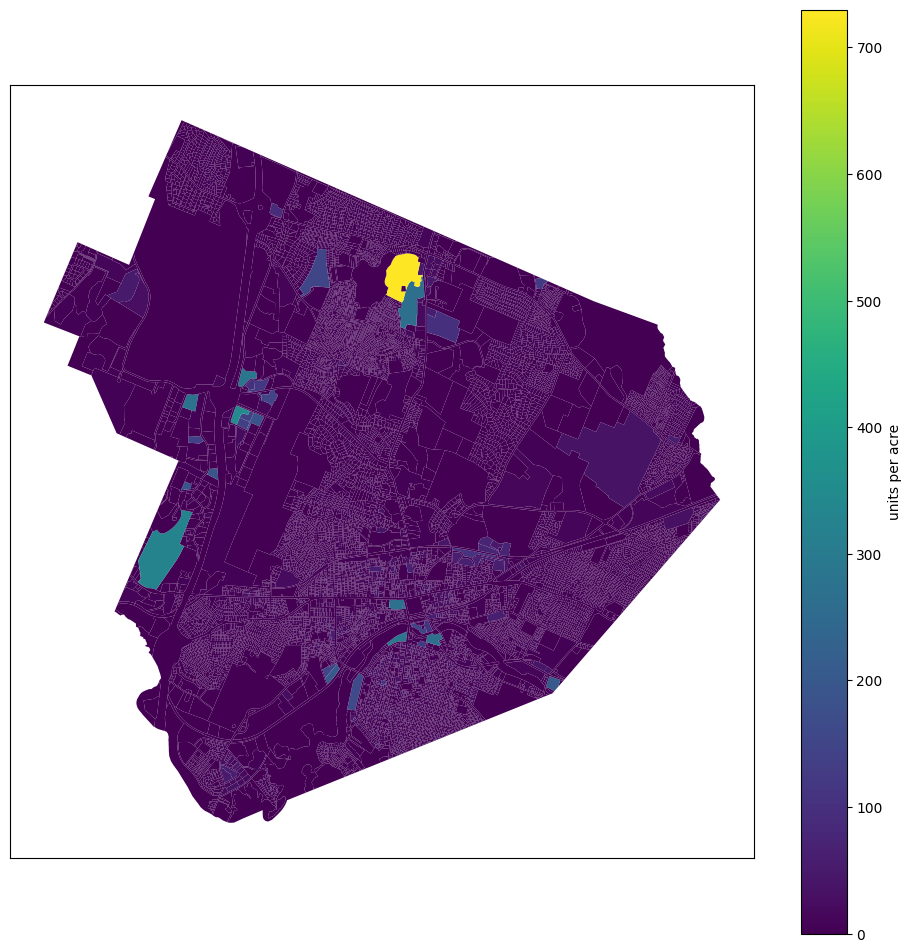

In [31]:
ax = properties_df.plot(column="LOCAL_DENSITY", legend=True, legend_kwds={'label': "units per acre"}, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Plotting the parcels

Unsurprisingly, they're all clustered near the river.

<Axes: >

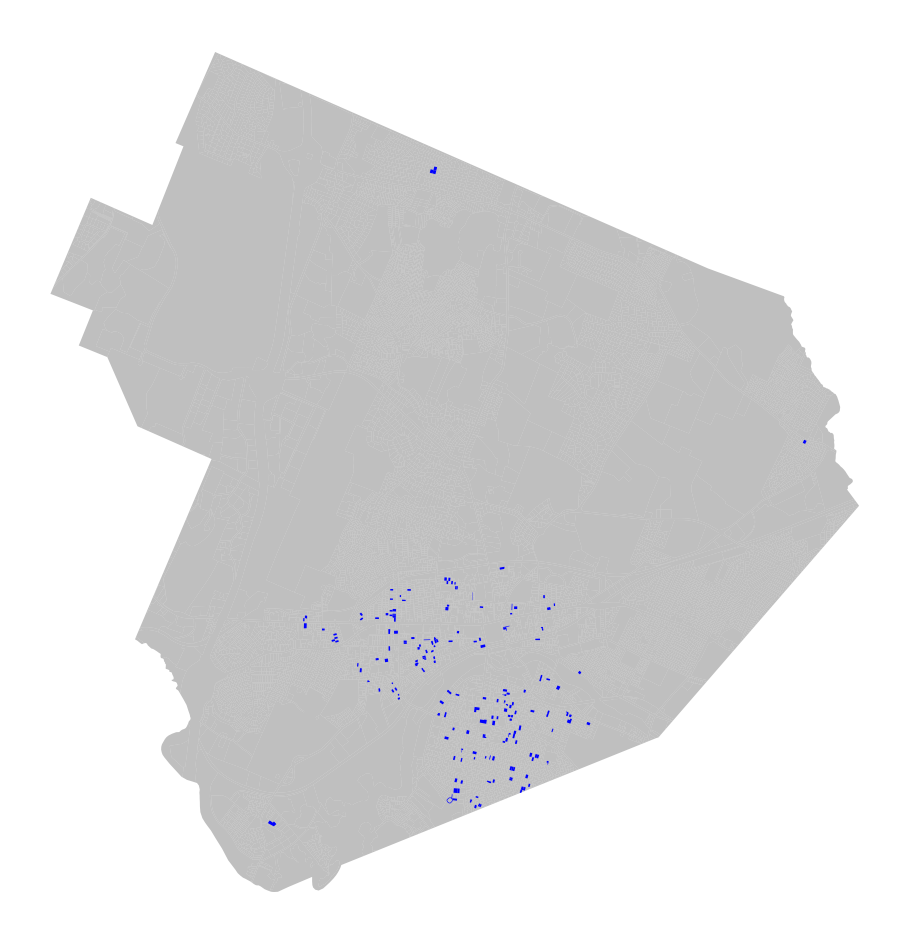

In [32]:
# plot the actual dense areas
base = properties_df.plot(color="gray", alpha=0.5, figsize=(12, 12))
base.set_axis_off()
MBTA_zoned_density_examples_df = properties_df[properties_df["LOCAL_DENSITY"] == MBTA_density]
MBTA_zoned_density_examples_df.plot(color="blue", zorder=100, ax=base)

## Existing parcels at or exceeding the MBTA density requirements

The law requires densities of 15 units / acre by-right. How many parcels do we have like this?

In [33]:
# parcels w/ >= 15 local density
meets_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] >= MBTA_density])

# remainder
low_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] < MBTA_density])

print(f"{low_density_count} / {len(properties_df)} are low density")
print(f"{meets_density_count} / {len(properties_df)} meet the minimum MBTA density (citywide)")

12553 / 13626 are low density
1073 / 13626 meet the minimum MBTA density (citywide)


... so less than 10% of our parcels are meeting this density. What about the number of units in these parcels?

In [34]:
# household unit counts in each group
meets_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] >= MBTA_density]["UNITS"].sum()

# remainder
low_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] < MBTA_density]["UNITS"].sum()

total_units = properties_df["UNITS"].sum()

print(f"{low_density_unit_count} / {total_units} unit counts in low density")
print(f"{meets_density_unit_count} / {total_units} unit counts in minimum MBTA density (citywide)")

15369.0 / 27755.0 unit counts in low density
12386.0 / 27755.0 unit counts in minimum MBTA density (citywide)


That's looking much better! About 44% of the units are in parcels of this density, which means there's a good chance you've spent time near or
in an area of this density. If we change our scale so the peak means '>15 units per acre', we'll get the plot below:

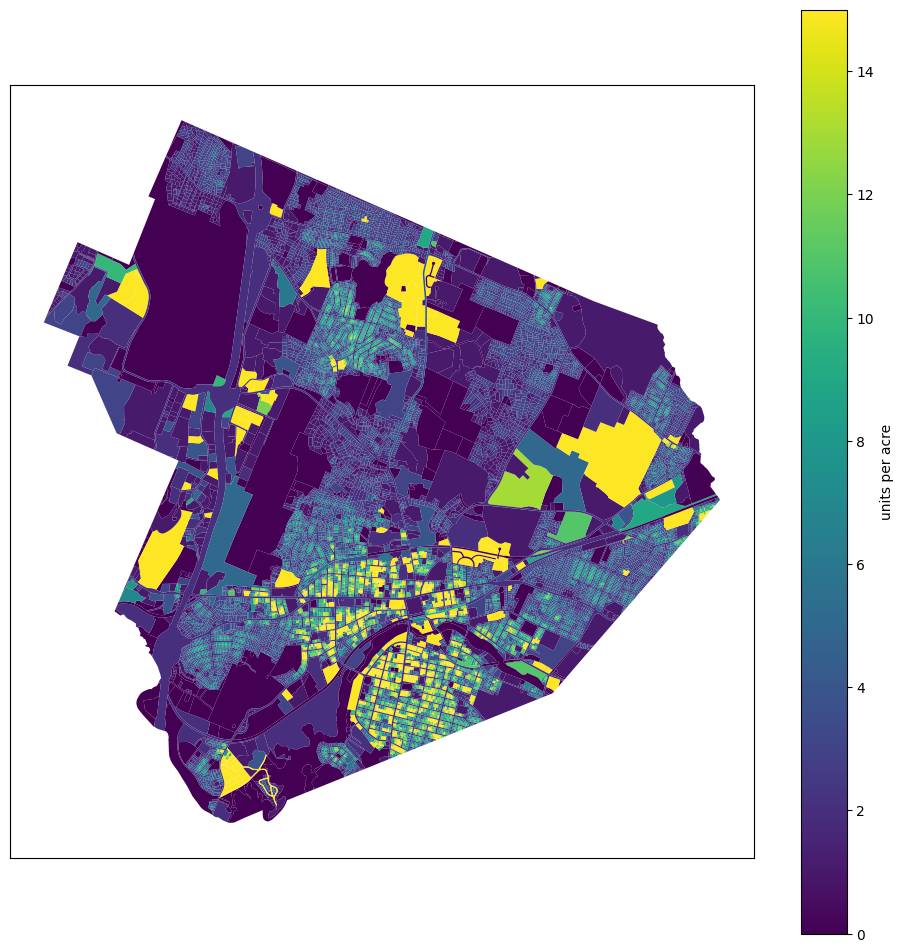

In [35]:
filtered_df = properties_df.copy()
filtered_df["LOCAL_DENSITY"] = filtered_df["LOCAL_DENSITY"].apply(lambda x: np.min([x, MBTA_density]))
filtered_df.head()
ax = filtered_df.plot(column="LOCAL_DENSITY", legend=True, legend_kwds={'label': "units per acre"}, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

A histogram is another way to look at this data; it's definitely left-skewed.

<Axes: xlabel='LOCAL_DENSITY', ylabel='Count'>

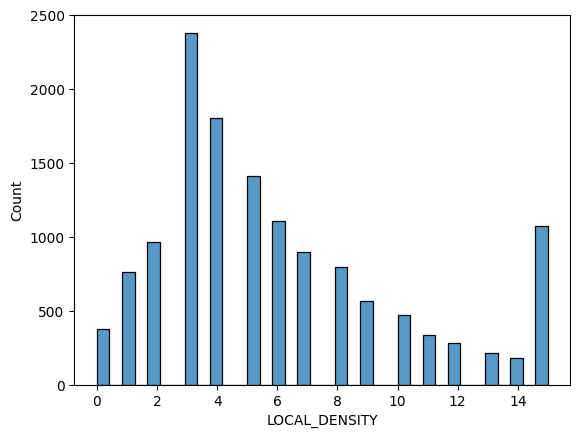

In [36]:
sns.histplot(data=filtered_df, x="LOCAL_DENSITY", kde=False)

# Parcel-level density

The zoning change that actually counts for the MBTA communities law is the number of units per acre - that's a straightforward calculation.

In [69]:
# NOTE: this is using the parcel polygon area in the shapefile's geometry units (m2) instead of the LOT_SIZE field, which is empty for MFH structures.
properties_df["PARCEL_DENSITY"] = properties_df["UNITS"] / (properties_df["SHAPE_Area"] / 4047) 

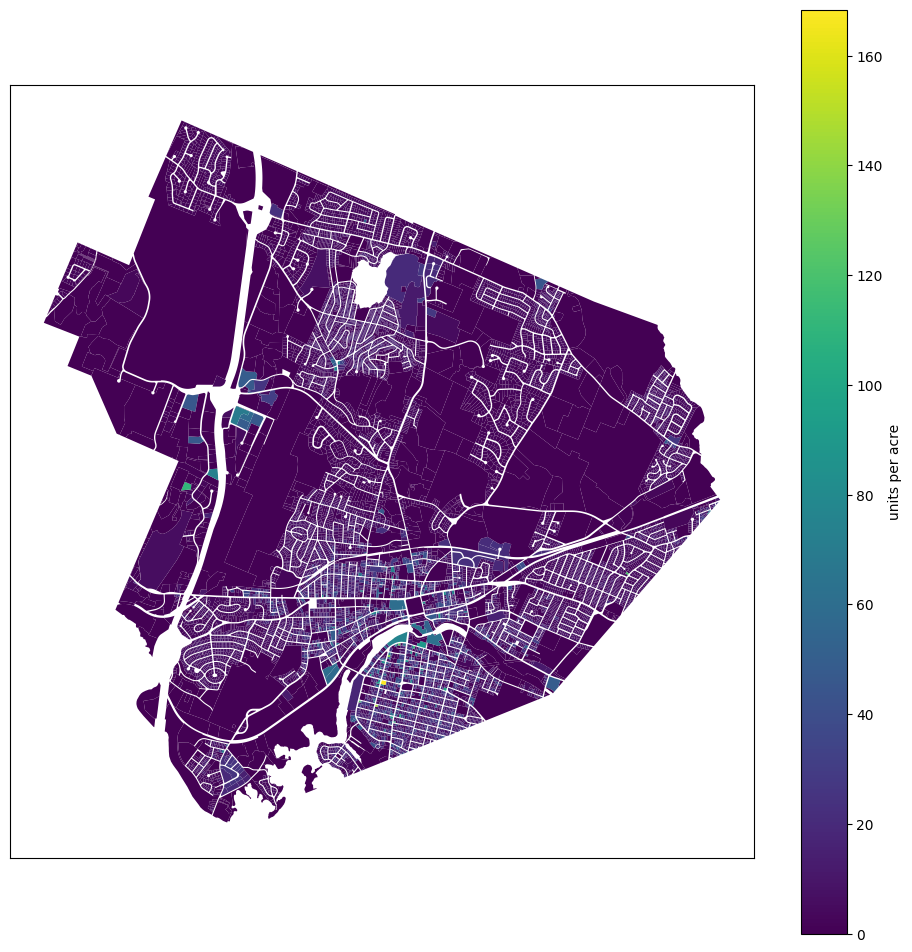

In [70]:
ax = properties_df.plot(column="PARCEL_DENSITY", legend=True, legend_kwds={'label': "units per acre"}, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)